In [5]:
import sys
sys.path.append("/Users/jasonbenn/code/neighborhood/neighborhood")

In [106]:
from utils import fetchall, chunks, flatten, sliding_window
import json
import datetime
import re
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import torch
import pandas as pd
np.set_printoptions(precision=2)
torch.set_printoptions(precision=2)
%matplotlib inline

# Parsing out event histories

In [161]:
IGNORED_EVENTS = ['Pending sale', 'Price change', 'Listed for sale']

def parse_history(history):
    raw_history = chunks(json.loads(history), 4)

    history = []
    for x in raw_history:
        if x[1] in IGNORED_EVENTS:
            continue
            
        if x[1] == "Listing removed" and x[2] in ["--", "-- "]:
            continue

        try:
            price = int(re.match("\$([\d,]+)", x[2]).group(1).replace(',', ''))
        except:
            print(x)
            raise

        history.append({
            'date': datetime.datetime.strptime(x[0], "%m/%d/%Y").date(),
            'type': x[1],
            'price': price
        })
    return history

In [224]:
async def query_to_examples(query: str):
    listings = await sync_to_async(lambda: fetchall(query))()
    print(f"num listings: {len(listings)}")
    events_by_type = Counter(flatten([[y[1] for y in chunks(json.loads(x['price_history']), 4)] for x in listings]))
    print("events_by_type", events_by_type)

    xs = []
    ys = []
    for listing in listings:
        parsed_history = parse_history(listing['price_history'])
        if len(parsed_history) < 2:
            continue
        listing_event_pairs = sliding_window(parsed_history, 2)

        for event_pair in listing_event_pairs:
            days_bw_events = (event_pair[0]['date'] - event_pair[1]['date']).days
            if event_pair[0]['type'] in ["Listing removed", "Listed for rent"]:
                xs.append({**listing, **{"owner_occupied": False}})
            else:
                xs.append({**listing, **{"owner_occupied": True}})
            ys.append(days_bw_events)

    return xs, ys

In [225]:
from asgiref.sync import sync_to_async

all_houses = """
select zil.apn, scraped_address, zestimate,  price_history, bool(mailing_address = site_address) owner_occupied, bedrooms, sqft, sqft / bedrooms sqft_per_br
from zillow_addresses zil
left join houses_owners ho on zil.apn = ho.apn
where jsonb_array_length(price_history) / 4 > 1;"""

xs, ys = await query_to_examples(all_houses)
examples = list(zip(xs, ys))

num listings: 1161
events_by_type Counter({'Sold': 1959, 'Listing removed': 679, 'Listed for sale': 607, 'Price change': 457, 'Listed for rent': 445, 'Pending sale': 350})


In [226]:
examples[0]

({'apn': '3540-032',
  'scraped_address': '2290-2292 15Th St, San Francisco, CA 94114',
  'zestimate': 2602500,
  'price_history': '["5/5/2004", "Sold", "$1,430,000 (+45.2%) $410/sqft", "Source:   Public Record Report a problem", "4/27/2000", "Sold", "$985,000  $282/sqft", "Source:   Public Record Report a problem"]',
  'owner_occupied': True,
  'bedrooms': None,
  'sqft': 3490,
  'sqft_per_br': None},
 1469)

# Datasets

In [227]:
oo = [x for x in examples if x[0]['owner_occupied']]
len(oo)

1168

In [228]:
noo = [x for x in examples if not x[0]['owner_occupied']]
len(noo)

758

# Distribution of all events

In [229]:
# I made this formula up based on the exponential distribution I wanted!
bins = 15 * 1.8 ** np.arange(12)
bins

array([  15.00,   27.00,   48.60,   87.48,  157.46,  283.44,  510.18,
        918.33, 1652.99, 2975.39, 5355.70, 9640.26])

In [230]:
def format_years(x, pos):
    if x < 30:
        return str(int(x)) + 'd'
    if x < 365:
        return str(round(x / 30, 1)) + 'm'
    return str(round(x / 365, 1)) + 'y'


def plot_dataset(days_bw_events):
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 2, 1.4])

    ax.semilogx(bins, np.zeros_like(bins))
    ax.hist(days_bw_events, bins=bins)
    ax.set_xlabel('Days between events')

    ax.xaxis.set_ticks(bins)
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1e8))  # hack: hide minor ticks
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_years))

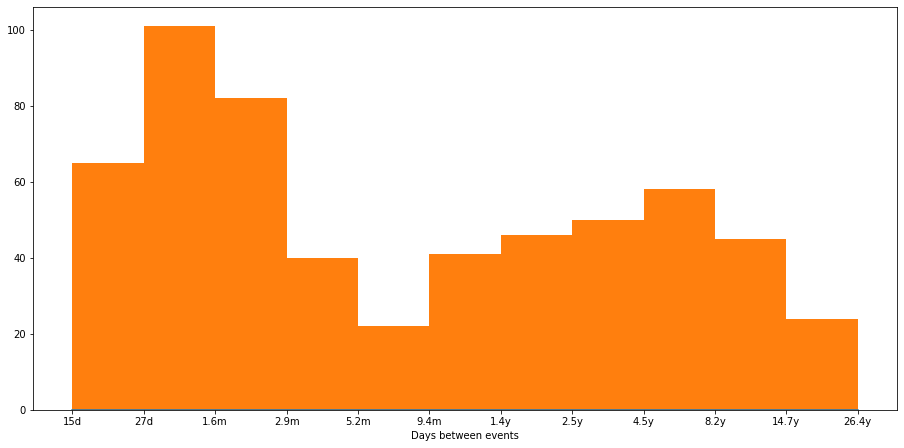

In [231]:
plot_dataset(np.array([x[1] for x in noo]))

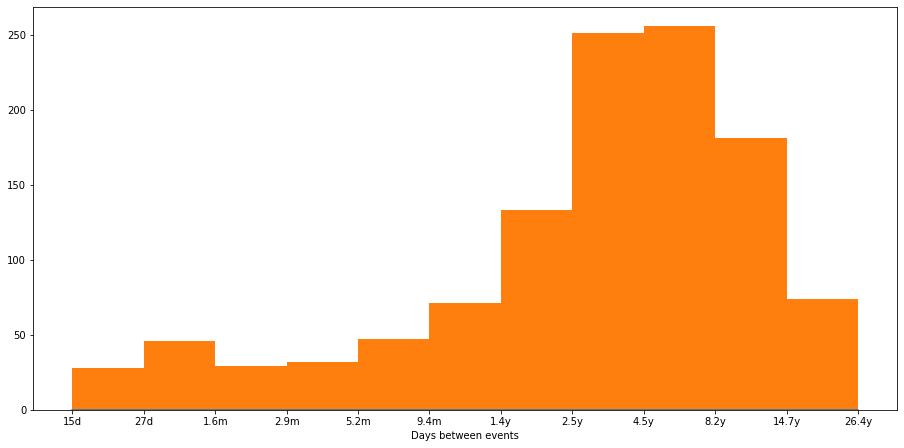

In [232]:
plot_dataset(np.array([x[1] for x in oo]))

# What do various existing distributions look like?

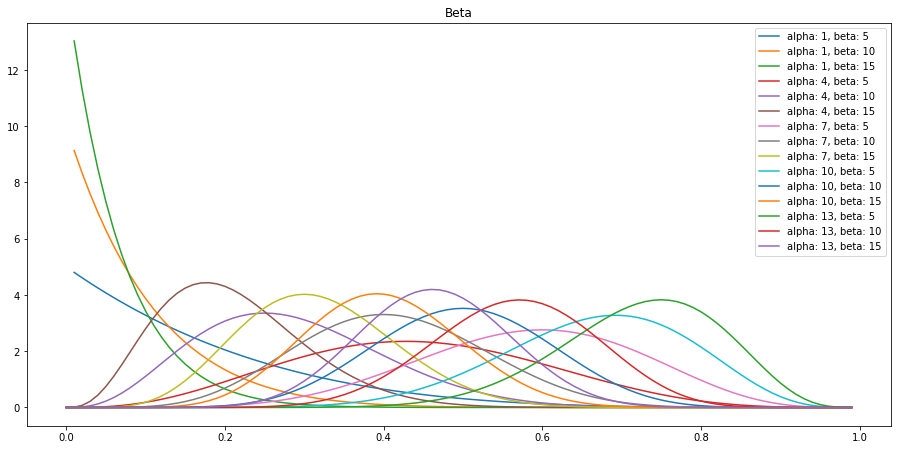

In [240]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 2, 1.4])

for alpha in np.arange(1, 15, 3):
    for beta in np.arange(5, 20, 5):
        dist = torch.distributions.Beta(alpha, beta)
        xs = torch.arange(0, 1, 0.01)
        ys = dist.log_prob(xs).exp()
        line, = ax.plot(xs, ys, '-', label=f"alpha: {alpha}, beta: {beta}")
        ax.legend()

ax.set_title("Beta")
plt.show()

# Training a model

In [245]:
len_dataset = len(examples)
num_train_examples = int(len_dataset * .8)
train_data = examples[:num_train_examples]
test_data = examples[num_train_examples:]
print(len(train_data), len(test_data))

1540 386
